<a href="https://colab.research.google.com/github/Calabras/obrabotka_izobrajheniy/blob/main/DE_IP_2024_Task_4_Shilin_ND_3823B1PR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

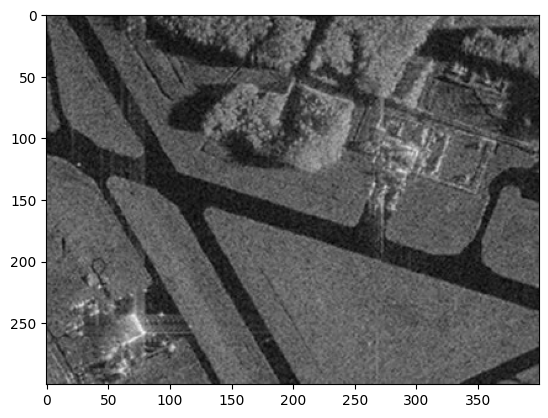

In [5]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

In [6]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])

    if abs(av_val - img[point]) <= T:
        return True

    return False


In [7]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask

    return mask*255


In [8]:
seed_point = (250,250)
mask = region_growing(image_gray,seed_point,homo_average,1, 10)

3
4
4
5
7
6
6
9
7
6
6
9
13
12
15
17
13
13
16
16
14
16
15
16
10
11
14
13
14
10
10
14
17
15
36
22
21
18
21
21
25
23
43
31
34
23
20
27
29
35
40
32
35
42
48
52
30
23
20
19
19
20
18
22
74
24
26
29
30
27
29
29
28
29
20
17
17
21
20
25
23
24
20
18
19
15
18
18
15
18
13
10
9
7
9
9
10
11
12
10
12
11
8
9
7
4
3
6
6
6
5
5
5
3
2
2
2
1
0


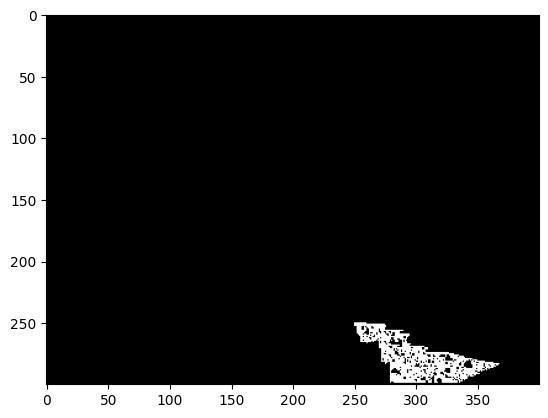

In [9]:
plt.imshow(mask, cmap="gray")

# K-means

In [10]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [11]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [12]:
z = image_gray.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

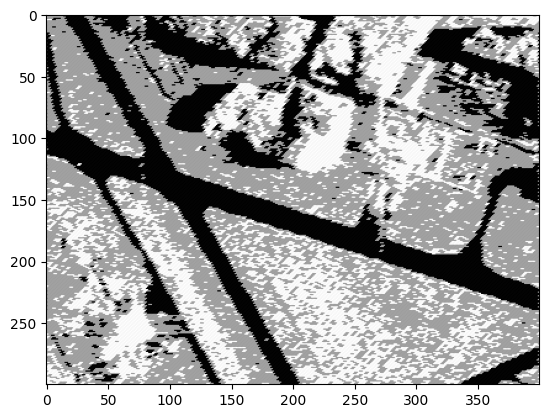

In [13]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [14]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

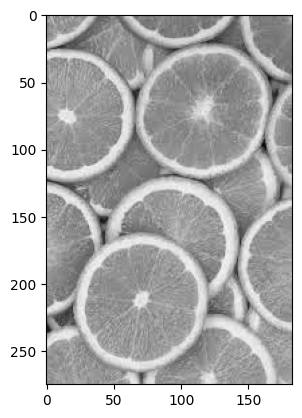

In [15]:
plt.imshow(image_gray, cmap="gray")

In [16]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

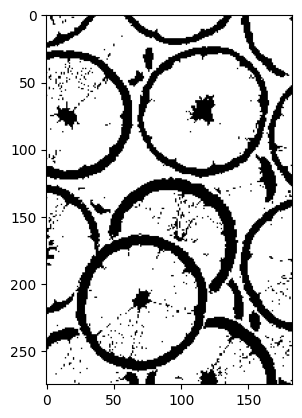

In [17]:
plt.imshow(thresh, cmap="gray")

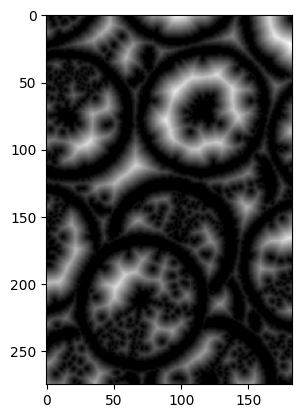

In [18]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
plt.imshow(dist, cmap="gray")

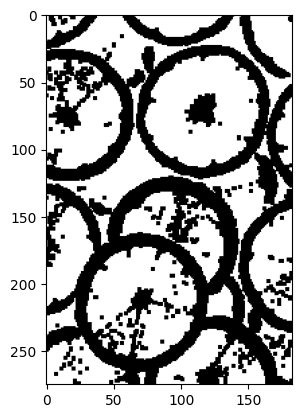

In [19]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
plt.imshow(sure_fg, cmap="gray")

In [20]:
sure_fg = sure_fg.astype(np.uint8)

In [21]:
ret, markers = cv2.connectedComponents(sure_fg)

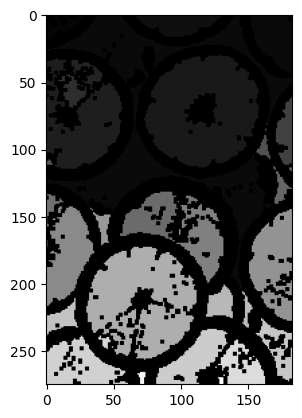

In [22]:
plt.imshow(markers, cmap="gray")

In [23]:
markers = cv2.watershed(image, markers)

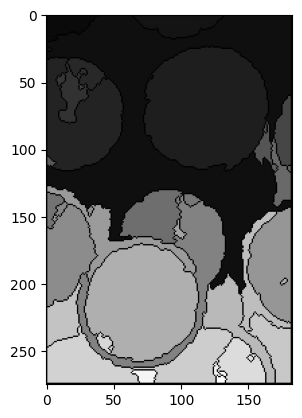

In [24]:
plt.imshow(markers, cmap="gray")

# Домашнее задание

In [25]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

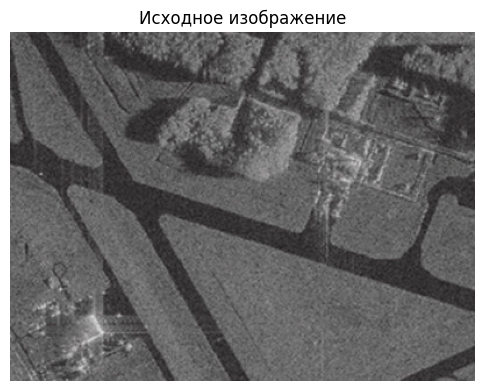

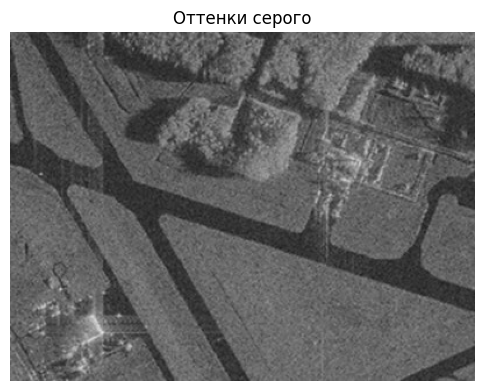

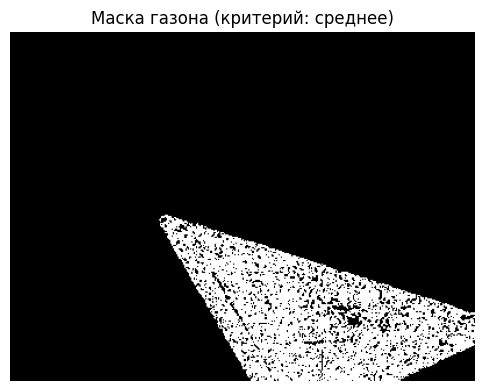

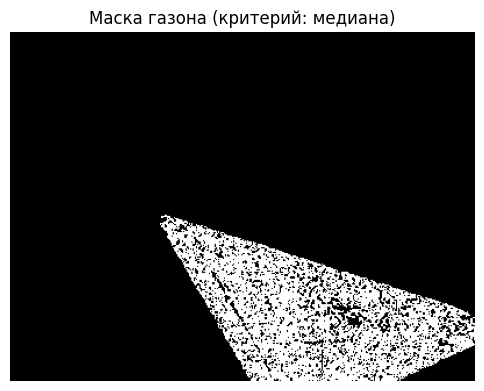

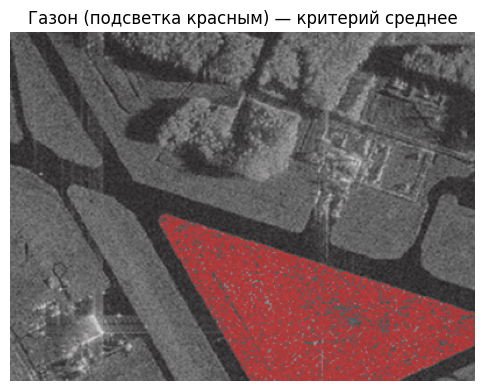

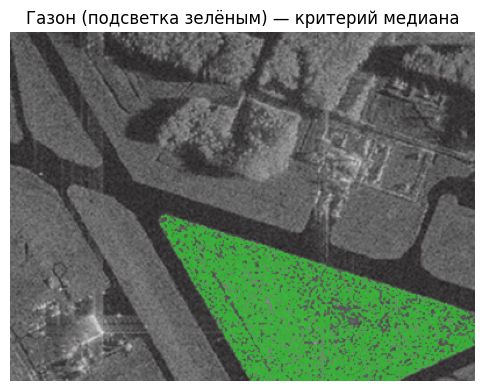

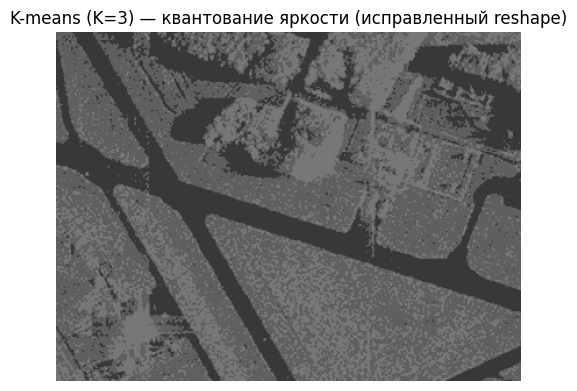

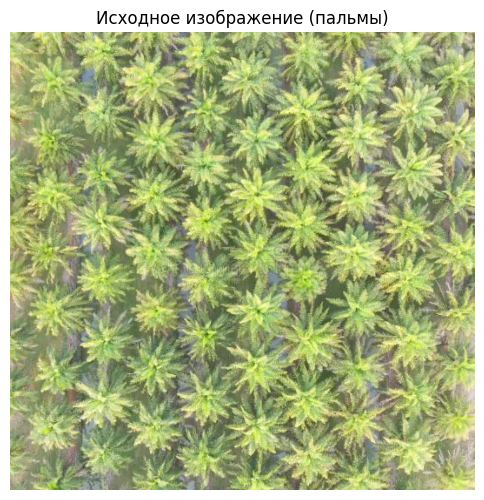

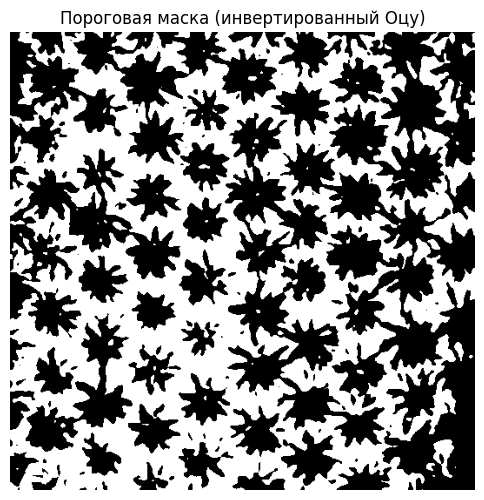

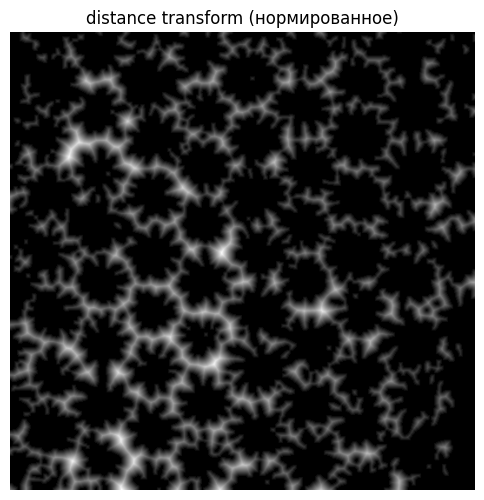

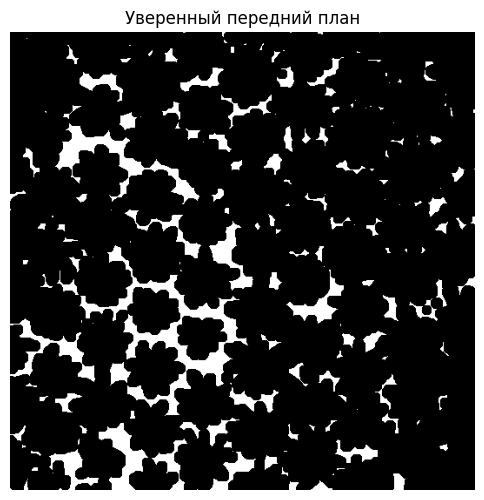

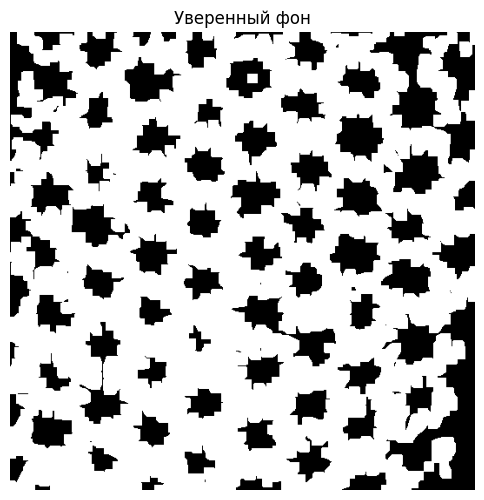

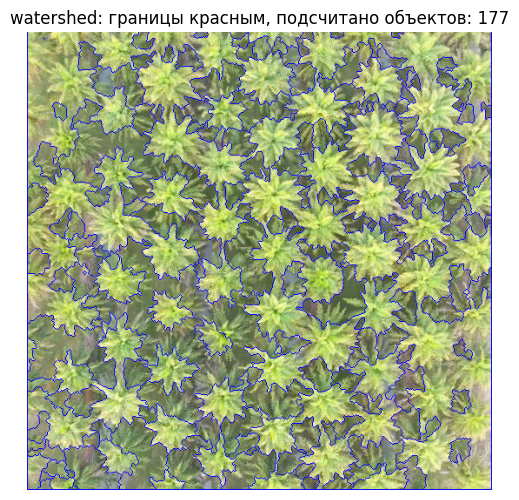

Количество пальмовых деревьев: 177


In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque

#вспомогательные функции

#одноканальное изображение (градации серого)
def show_gray(img, title='', size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()

#bgr изображение
def show_bgr(img_bgr, title='', size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

#бинарная маска на изображение цветной полупрозрачной подсветкой
def overlay_mask(img_bgr, mask, color=(0, 0, 255), alpha=0.45):
    if mask.shape != img_bgr.shape[:2]:
        raise ValueError(f'Размеры маски {mask.shape} не совпадают с изображением {img_bgr.shape[:2]}')

    mask_bool = (mask > 0)
    color_img = np.full_like(img_bgr, color, dtype=np.uint8)
    blended = cv2.addWeighted(img_bgr, 1 - alpha, color_img, alpha, 0)
    out = img_bgr.copy()
    out[mask_bool] = blended[mask_bool]
    return out

#критерий однородности
def homo_mean(img, mask, point, T):
    region = img[mask > 0]
    if region.size == 0:
        return True
    av_val = float(region.mean())
    return abs(av_val - float(img[point])) <= T

#критерий однородности (устойчивый)
def homo_median_mad(img, mask, point, T):
    region = img[mask > 0]
    if region.size == 0:
        return True
    med = float(np.median(region))
    return abs(float(img[point]) - med) <= T

#разрастание региона (BFS)
def region_growing(img_gray, seed_point, homo_fun, r=1, T=10, connectivity=8, max_pixels=None):
    H, W = img_gray.shape
    mask = np.zeros((H, W), np.uint8)
    visited = np.zeros((H, W), np.uint8)

    q = deque()
    sr, sc = seed_point
    if not (0 <= sr < H and 0 <= sc < W):
        raise ValueError('seed_point вне изображения.')
    mask[sr, sc] = 1
    visited[sr, sc] = 1
    q.append((sr, sc))

    offsets = []
    for dr in range(-r, r + 1):
        for dc in range(-r, r + 1):
            if dr == 0 and dc == 0:
                continue
            if connectivity == 4 and abs(dr) + abs(dc) != 1:
                continue
            offsets.append((dr, dc))

    added = 1
    while q:
        r0, c0 = q.popleft()
        for dr, dc in offsets:
            rr, cc = r0 + dr, c0 + dc
            if 0 <= rr < H and 0 <= cc < W and not visited[rr, cc]:
                visited[rr, cc] = 1
                if homo_fun(img_gray, mask, (rr, cc), T):
                    mask[rr, cc] = 1
                    q.append((rr, cc))
                    added += 1
                    if max_pixels is not None and added >= max_pixels:
                        break
        if max_pixels is not None and added >= max_pixels:
            break

    return (mask * 255).astype(np.uint8)


#kmeans для серого изображения
def kmeans_gray(image_gray, K=3, max_iter=10):
    z = image_gray.reshape((-1, 1)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, int(max_iter), 1.0)
    ret, label, center = cv2.kmeans(z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(image_gray.shape)
    return res2

#watershed + distance transform для подсчёта объектов (пальм)
def watershed_palm_count(img_bgr, thresh_mode='inv_otsu', dist_thresh_ratio=0.35):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (9, 9), 0)

    if thresh_mode == 'inv_otsu':
        _, thresh = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        _, thresh = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, dist_thresh_ratio * dist.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)

    unknown = cv2.subtract(sure_bg, sure_fg)

    num_labels, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img_bgr, markers)

    unique_labels = np.unique(markers)
    count = int(np.sum((unique_labels > 1)))

    overlay = img_bgr.copy()
    overlay[markers == -1] = [255, 0, 0]

    return markers, count, overlay, thresh, dist, sure_fg, sure_bg

#разрастание регионов: выделение газона
img = cv2.imread('sar_1.jpg')
if img is None:
    raise FileNotFoundError('Не удалось загрузить sar_1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show_bgr(img, 'Исходное изображение')
show_gray(gray, 'Оттенки серого')

seed_point = (250, 250)

#базовый критерий
mask_mean = region_growing(gray, seed_point, homo_fun=homo_mean, r=1, T=12, connectivity=8)
#устойчивый (медианный) критерий
mask_med = region_growing(gray, seed_point, homo_fun=homo_median_mad, r=1, T=10, connectivity=8)

show_gray(mask_mean, 'Маска газона (критерий: среднее)')
show_gray(mask_med,  'Маска газона (критерий: медиана)')

ov_mean = overlay_mask(img, mask_mean, color=(0, 0, 255), alpha=0.45)
ov_med  = overlay_mask(img, mask_med,  color=(0, 255, 0), alpha=0.45)

show_bgr(ov_mean, 'Газон (подсветка красным) — критерий среднее')
show_bgr(ov_med,  'Газон (подсветка зелёным) — критерий медиана')

#k-means для серого (исправленный reshape) изображения
res_k3 = kmeans_gray(gray, K=3, max_iter=10)
show_gray(res_k3, 'K-means (K=3) — квантование яркости (исправленный reshape)')

#watershed + distance transform: подсчёт пальм
palm = cv2.imread('palm_1.JPG')
if palm is None:
    raise FileNotFoundError('Не удалось загрузить palm_1.JPG')

markers, count, overlay, thresh, dist, sure_fg, sure_bg = watershed_palm_count(
    palm, thresh_mode='inv_otsu', dist_thresh_ratio=0.35
)

show_bgr(palm, 'Исходное изображение (пальмы)')
show_gray(thresh, 'Пороговая маска (инвертированный Оцу)')
show_gray((dist / dist.max() * 255).astype(np.uint8), 'distance transform (нормированное)')
show_gray(sure_fg, 'Уверенный передний план')
show_gray(sure_bg, 'Уверенный фон')
show_bgr(overlay, f'watershed: границы красным, подсчитано объектов: {count}')

print(f'Количество пальмовых деревьев: {count}')
